In [1]:
%matplotlib inline
from nldi_xstool.XSGen import XSGen
from nldi_xstool.dem_query import query_dems_shape
from nldi_xstool.nldi_xstool import getXSAtPoint, getXSAtEndPts
from shapely.geometry import LineString, Point
import py3dep
from pynhd import NLDI, NHDPlusHR, WaterData
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import dataretrieval.nwis as nwis
import requests

In [2]:
# The following function converts NGVD29 to NAVD88 if gage is in NGVD29 using NOAA NGS Vertcon service api
# https://www.ngs.noaa.gov/web_services/ncat/lat-long-height-service.shtml

def getGageDatum(gagenum, verbose=False):
    si = nwis.get_record(sites=gagenum, service='site')
    if si['alt_datum_cd'].values[0] == 'NGVD29':
#         print('conversion')
        url = "https://www.ngs.noaa.gov/api/ncat/llh"
        lat_str = 'lat_va'
        lon_str = 'long_va'

        alt_str = 'alt_va'
        indatum_str = 'coord_datum_cd'
        outdatum_str = 'NAD83(2011)'
        inVertDataum_str = 'NGVD29'
        outVertDataum = 'NAVD88'
        if f'{si[indatum_str].values[0]}' == 'NAD83':
            indatum = 'NAD83(2011)'
        else:
            indatum = f'{si[indatum_str].values[0]}'

        ohgt = float(si[alt_str].values[0])*.3048
        
        tmplonstr = si[lon_str].values[0]

        if len(str(tmplonstr)) == 6:
            tstr = '0'
            tmplonstr = (tstr + str(tmplonstr))

        payload = {
            'lat':f'N{si[lat_str].values[0]}',
            'lon':f'W{tmplonstr}',
            'orthoHt': repr(ohgt),
            'inDatum':indatum,
            'outDatum':outdatum_str,
            'inVertDatum':inVertDataum_str,
            'outVertDatum':outVertDataum 
        }
        r = requests.get(url, params=payload)
        resp = r.json()
        if verbose:
            print(f'{si[indatum_str].values[0]}')
            print(f'payload: {payload}')
            print(resp)
        return float(resp['destOrthoht'])
    else:
#         print('non-conversion')
        return si['alt_va'].values[0]*.3048

## Create Dictionary of Threshold gage sites where path is location of left-bank and right-bank, both estimated using google earth

In [9]:
threshold_gages ={'02335350': {'path': [(-84.265284, 33.964690), (-84.264037, 33.965374)], 'Thresholds': {1: {'Type':'Road', 'Value': 17.73, 'Name': 'Street: Suwanee Dam Road'}, 2: {'Type':'Top Of Bank', 'Value': 8.85, 'Name': 'Bankfull'}}},
                  '02334480': {'path': [(-84.069592, 34.132959), (-84.070461, 34.131941)], 'Thresholds': {1: {'Type':'Top Of Bank', 'Value': 11.37, 'Name': 'Bankfull'}, 2: {'Type':'Bridge Deck', 'Value': 19.53, 'Name': 'Bridge Deck Elevation'}}},
                  '02207055': {'path': [(-84.059534, 33.824598), (-84.058593, 33.825617)], 'Thresholds': {1: {'Type':'Top Of Bank', 'Value': 2.66, 'Name': 'Bankfull'}, 2: {'Type':'Bridge Deck', 'Value': 3.37, 'Name': 'Bridge Deck Elevation'}}},
                  '03321350': {'path': [(-86.888014, 37.618517), (-84.058479, 37.619308)], 'Thresholds': {1:{'Type':'Top Of Bank', 'Value': 15.5, 'Name': 'Bankfull'}}}
                 }

## Iterate through dictionary to calculate:
* Gage Datum
* Gage Comid
* 3DEP DEM dictionary of available resolution to provide context to quality of cross-section
* Cross-section using NHGF projects NLDI_XSTools package (soon to be web-service)

In [7]:
gage_datum_m = []
gage_comid = []
dem_res = []
cross_sections = []
for index, gage in enumerate(threshold_gages):
    
    gage_datum_m.append(getGageDatum(gage, verbose=False))
    gageloc = NLDI().getfeature_byid('nwissite', f'USGS-{gage}')
    gage_comid.append(gageloc.comid.values.astype(int)[0])
    x = gageloc.geometry.x[0]
    y = gageloc.geometry.y[0]
    print(gage, x, y, gage_comid[index], gage_datum_m[index])
    path = threshold_gages[gage]['path']
    cross_sections.append(getXSAtEndPts(threshold_gages[gage]['path'], 101, res=1.0))
    lnst = []
    for pt in path:
        lnst.append(Point(pt[0], pt[1]))
    bbox = LineString(lnst).envelope.bounds
    dem_res.append(query_dems_shape(bbox))

02335350 -84.2647236518527 33.964997982470955 2048057 265.11504
02334480 -84.07000112324023 34.13249789061552 2044673 281.6352
02207055 -84.05888911794524 33.825276066697626 6333496 254.8128
03321350 -86.88749028943637 37.61893664346803 11616503 121.810272


In [39]:
# Function to plot gage cross-section and threshold values
def plot_gage(index):
    colors=['r', 'g', 'b']
    for ind, (k, v) in enumerate(threshold_gages.items()):
        if ind == index:
            print(f'Available DEM Resolution {dem_res[index]}')
            fig, ax = plt.subplots()
            plt.title(f'USGS Gage {k}')
            cross_sections[index].plot.line(x='distance', y='elevation', ax=ax)
#             print(v['Thresholds'])
            for ind2, (thresh_k, thresh_v) in enumerate(v['Thresholds'].items()):
    #             print(ind2, thresh_v)
                ax.axhline(y=(thresh_v['Value']*.3048)+gage_datum_m[index], color=colors[ind2], linestyle='-', label=thresh_v['Name'])
            plt.legend()

Available DEM Resolution {'res_1m': False, 'res_3m': True, 'res_5m': False, 'res_10m': True, 'res_30m': True, 'res_60m': False}


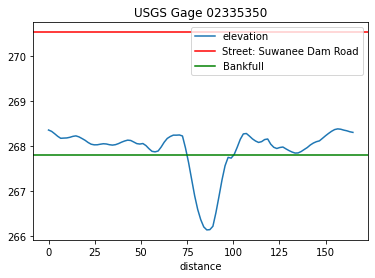

In [40]:
index = 0
plot_gage(index)

Available DEM Resolution {'res_1m': False, 'res_3m': True, 'res_5m': False, 'res_10m': True, 'res_30m': True, 'res_60m': False}


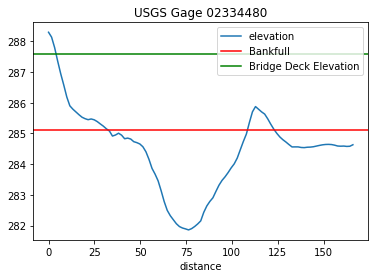

In [41]:
index = 1
plot_gage(index)

Available DEM Resolution {'res_1m': False, 'res_3m': False, 'res_5m': False, 'res_10m': True, 'res_30m': True, 'res_60m': False}


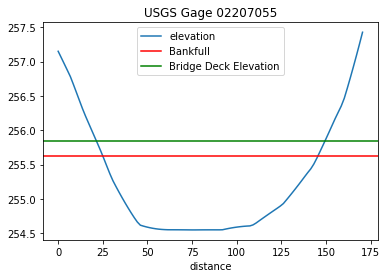

In [42]:
index = 2
plot_gage(index)

Available DEM Resolution {'res_1m': False, 'res_3m': False, 'res_5m': False, 'res_10m': True, 'res_30m': True, 'res_60m': False}


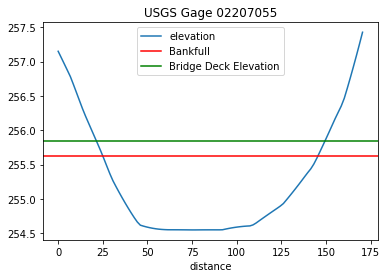

In [43]:
index = 2
plot_gage(index)